## LibSBML

In [1]:
import libsbml as sbml
import jax
import jax.numpy as jnp
from jax import tree
import diffrax

In [3]:
reader = sbml.SBMLReader()

In [ ]:
doc = reader.readSBMLFromFile("M:/enzax_clone/src/enzax/examples/exampleode.xml")
doc.getNumErrors()

0

In [17]:
doc = reader.readSBMLFromFile("M:/enzax_clone/src/enzax/examples/brusselator.xml")
doc.getNumErrors()

0

In [18]:
Model_lib = doc.getModel()
Model_lib.getNumSpecies()

6

In [8]:
Model_lib.reactions[0]

<Reaction r1 "r1">

In [9]:
Model_lib.getListOfRules()

<ListOfRules[0]>

In [10]:
r = Model_lib.getListOfReactions()[0]

In [11]:
law0 = Model_lib.getListOfFunctionDefinitions()[0]

In [13]:
if doc.getModel().getNumFunctionDefinitions():
    convert_config = (sbml.SBMLFunctionDefinitionConverter().getDefaultProperties())
    doc.convert(convert_config)

model_new = doc.getModel()
r_law01 = model_new.getListOfReactions()[0].getKineticLaw()
sbml.formulaToL3String(r_law01.getMath())

'Cytosol * (E10 * Kcat * (A / Kms - B / Kms / Keq) * 1 / (1 + A / Kms + B / Kmp + D / Ki))'

# Function
Things to be fixed:  
It simulates all species not only balanced_species.  
It can't handle "X^2" in "brusselator.xml" 

In [20]:
import libsbml as sbml
import jax
import jax.numpy as jnp
from jax import tree
import diffrax

jax.config.update("jax_enable_x64", True)

In [ ]:
# Load and parse the SBML model
def load_sbml_model(file_path):
    reader = sbml.SBMLReader()
    doc = reader.readSBML(file_path)
    if doc.getModel().getNumFunctionDefinitions():
        convert_config = sbml.SBMLFunctionDefinitionConverter().getDefaultProperties()
        doc.convert(convert_config)
    model = doc.getModel()
    if model is None:
        raise ValueError("Failed to load the SBML model")
    return model

# Extract species, reactions and parameters
def extract_model_info(model):
    species = [s.getId() for s in model.getListOfSpecies()]
    compartments ={c.getId(): c.volume for c in model.getListOfCompartments()}
    
    balanced_ix =  []
    balanced_species = []
    unbalanced_ix = []
    unbalanced_species = []
    for i in range(0, model.getNumSpecies()):
        if model.getListOfSpecies()[i].boundary_condition == False:
            balanced_ix.append(i)
            balanced_species.append(model.getListOfSpecies()[i].getId())
        else:
            unbalanced_ix.append(i)
            unbalanced_species.append(model.getListOfSpecies()[i].getId())
    
    # Stoichiometric matrix for all species, also enzymes. 
    stoichmatrix  = jnp.zeros((model.getNumReactions(), model.getNumSpecies(), model.getNumReactions()), dtype=int)
    i = 0 
    for reaction in model.getListOfReactions():
        for r in reaction.getListOfReactants():
            stoichmatrix = stoichmatrix.at[species.index(r.getSpecies()), i].set(-int(r.getStoichiometry()))
        for p in reaction.getListOfProducts():
            stoichmatrix = stoichmatrix.at[species.index(p.getSpecies()), i].set(int(p.getStoichiometry()))
        i+=1

    reactions = []
    for reaction in model.getListOfReactions():
        kinetic_law = reaction.getKineticLaw()
        rate = sbml.formulaToL3String(kinetic_law.getMath())
        reactants = [(r.getSpecies(), int(r.getStoichiometry())) for r in reaction.getListOfReactants()]
        products = [(p.getSpecies(), int(p.getStoichiometry())) for p in reaction.getListOfProducts()]
        parameters = {p.getId(): p.getValue() for p in kinetic_law.getListOfParameters()}
        reactions.append({'rate': rate, 'reactants': reactants, 'products': products, 'parameters': parameters})
    return species, compartments, balanced_species, unbalanced_species, stoichmatrix, reactions

# Define the ODE system for diffrax
def ode_system(t, y, args):
    species, compartments, balanced_species, unbalanced_species, stoichmatrix, reactions = args
    dydt = list(tuple(0. for _ in range(len(species))))

    # Evaluate the rate laws for each reaction. For now all species are evaluated, not only balanced species. 
    for reaction in reactions:
        rate = eval(reaction['rate'], {**reaction['parameters'], **compartments, **dict(zip(species, y))})
        for reactant, stoich in reaction['reactants']:
            dydt[species.index(reactant)] -= stoich * rate
        for product, stoich in reaction['products']:
            dydt[species.index(product)] += stoich * rate

    return dydt

# Main function to run the simulation
def run_simulation(model, initial_conditions, t0, t1, dt):
    species, compartments, balanced_species, unbalanced_species, stoichmatrix, reactions = extract_model_info(model)
    ode_func = diffrax.ODETerm(ode_system)
    
    solver = diffrax.Tsit5() 
    sol = diffrax.diffeqsolve(
        ode_func,
        solver=solver,
        t0=t0,
        t1=t1,
        dt0=dt,
        y0=initial_conditions,
        args=(species, compartments, balanced_species, unbalanced_species, stoichmatrix, reactions),
        saveat = diffrax.SaveAt(ts=jnp.linspace(t0, t1, 100)) # saves 100 timesteps 
    )
    return sol


In [4]:
# Load the model and run the simulation
model = load_sbml_model("M:/enzax_clone/src/enzax/examples/exampleode.xml") # Path on my computer. Need to be fixed

initial_conditions = [s.getInitialConcentration() for s in model.getListOfSpecies()]

t0, t1, dt = 0, 15, 0.1  # Example time settings

solution = run_simulation(model, initial_conditions, t0, t1, dt)


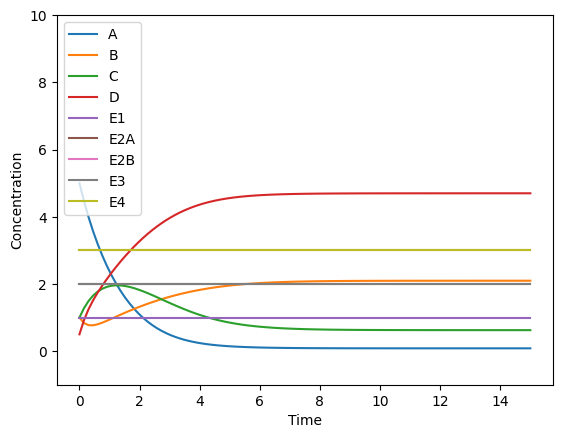

In [5]:
# Plot or print the results
import matplotlib.pyplot as plt
time_points = solution.ts
species_values = solution.ys

for i, species_name in enumerate([s.getId() for s in model.getListOfSpecies()]):
    plt.plot(time_points, species_values[i], label=species_name)

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.ylim([-1,10])
plt.legend()
plt.show()
